In [17]:
%load_ext autoreload
%autoreload 2

from util import *
from myalgorithm import algorithm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import os
import traceback

file_name=  'STAGE1_1.json'

problem_file = os.path.join("stage1_problems", file_name)
timelimit = 30


with open(problem_file, 'r') as f:
    prob = json.load(f)

K = prob['K']

ALL_ORDERS = [Order(order_info) for order_info in prob['ORDERS']]
ALL_RIDERS = [Rider(rider_info) for rider_info in prob['RIDERS']]

DIST = np.array(prob['DIST'])
for r in ALL_RIDERS:
    r.T = np.round(DIST/r.speed + r.service_time)

alg_start_time = time.time()

exception = None

solution = None
bundles = None

try:
    # Run algorithm!
    solution, bundles, weight = algorithm(K, ALL_ORDERS, ALL_RIDERS, DIST, timelimit)
except Exception as e:
    exception = f'{e}'
    print(traceback.format_exc())


alg_end_time = time.time()

with open(problem_file, 'r') as f:
    prob = json.load(f)

K = prob['K']

ALL_ORDERS = [Order(order_info) for order_info in prob['ORDERS']]
ALL_RIDERS = [Rider(rider_info) for rider_info in prob['RIDERS']]

DIST = np.array(prob['DIST'])
for r in ALL_RIDERS:
    r.T = np.round(DIST/r.speed + r.service_time)

checked_solution = solution_check(K, ALL_ORDERS, ALL_RIDERS, DIST, solution)

checked_solution['time'] = alg_end_time - alg_start_time
checked_solution['timelimit_exception'] = (alg_end_time - alg_start_time) > timelimit + 1 # allowing additional 1 second!
checked_solution['exception'] = exception

checked_solution['prob_name'] = prob['name']
checked_solution['prob_file'] = problem_file

checked_solution

KeyboardInterrupt: 

In [ ]:
for bundle in bundles['BIKE']:
    bundle.shop_seq

[Bundle(all_orders, BIKE, [0], [0], 21, True),
 Bundle(all_orders, BIKE, [1], [1], 12, True),
 Bundle(all_orders, BIKE, [2], [2], 22, True),
 Bundle(all_orders, BIKE, [3], [3], 44, True),
 Bundle(all_orders, BIKE, [4], [4], 16, True),
 Bundle(all_orders, BIKE, [5], [5], 18, True),
 Bundle(all_orders, BIKE, [6], [6], 22, True),
 Bundle(all_orders, BIKE, [7], [7], 17, True),
 Bundle(all_orders, BIKE, [8], [8], 18, True),
 Bundle(all_orders, BIKE, [9], [9], 11, True),
 Bundle(all_orders, BIKE, [10], [10], 15, True),
 Bundle(all_orders, BIKE, [11], [11], 30, True),
 Bundle(all_orders, BIKE, [12], [12], 37, True),
 Bundle(all_orders, BIKE, [13], [13], 14, True),
 Bundle(all_orders, BIKE, [14], [14], 84, True),
 Bundle(all_orders, BIKE, [15], [15], 16, True),
 Bundle(all_orders, BIKE, [16], [16], 20, True),
 Bundle(all_orders, BIKE, [17], [17], 16, True),
 Bundle(all_orders, BIKE, [18], [18], 18, True),
 Bundle(all_orders, BIKE, [19], [19], 32, True),
 Bundle(all_orders, BIKE, [20], [20], 32

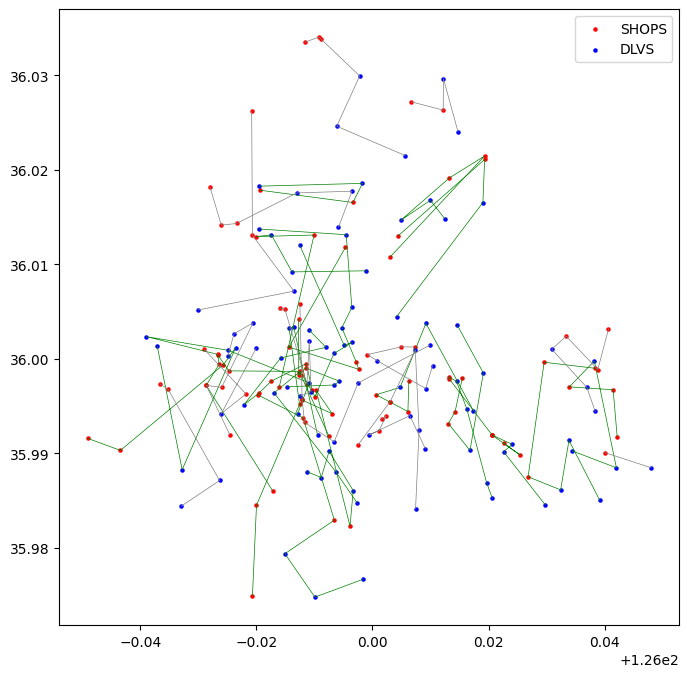

In [151]:
draw_route_solution(ALL_ORDERS, checked_solution)

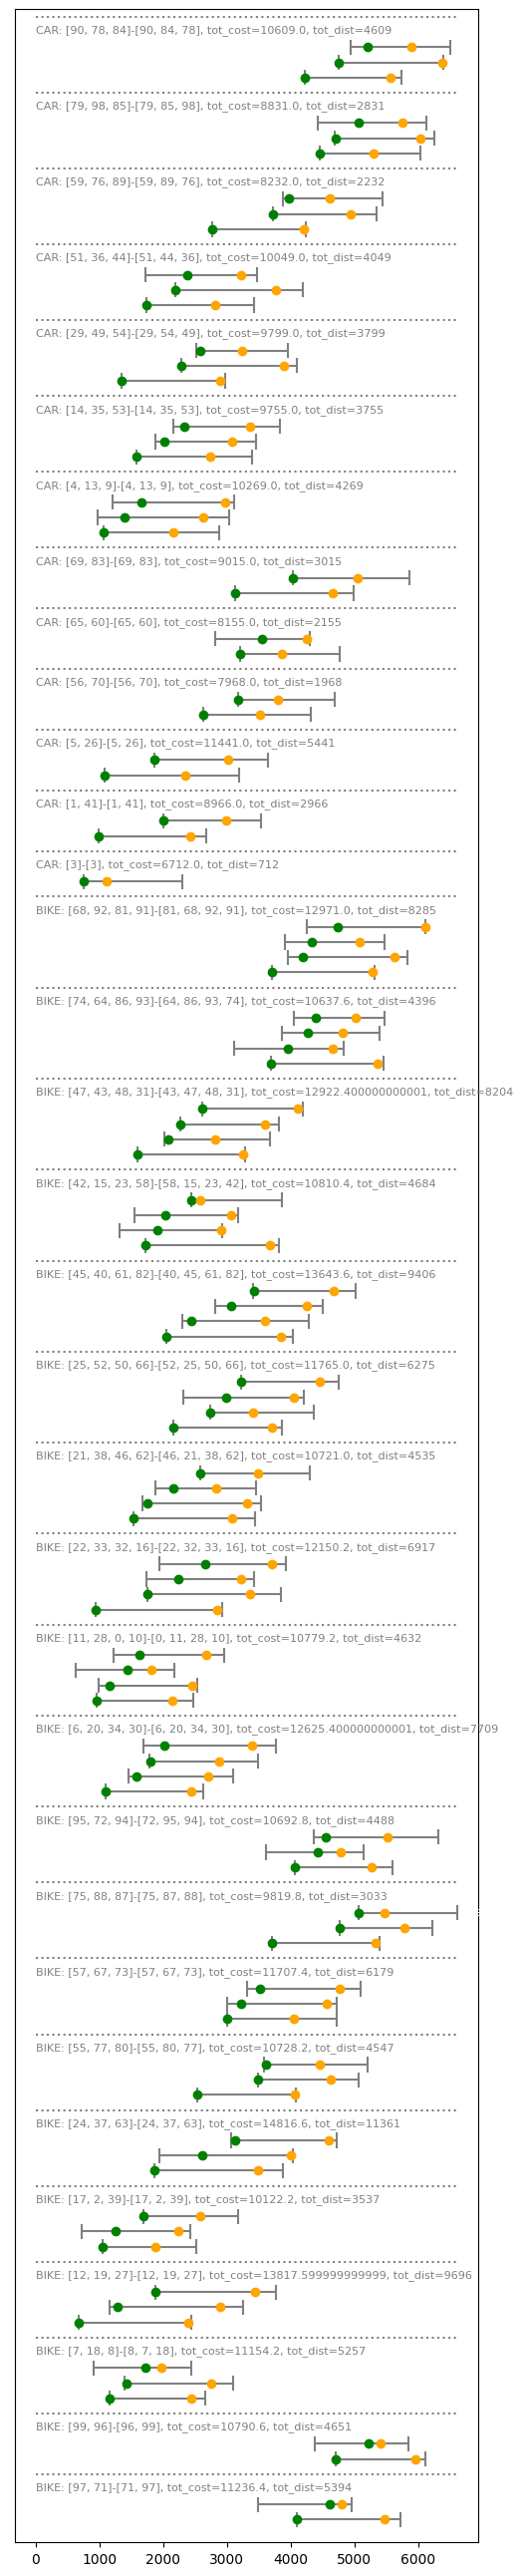

In [142]:
draw_bundle_solution(ALL_ORDERS, ALL_RIDERS, DIST, checked_solution)